[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/geometry_generate_patch.ipynb)

# Image patch generation

In this tutorial we are going to learn how to generate image patches using `kornia.geometry` components.


In [ ]:
%%capture
!pip install kornia matplotlib

In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


download_image("https://github.com/kornia/data/raw/main/homography/img1.ppm")

'img1.ppm'

First load libraries and images

In [ ]:
%matplotlib inline
import cv2
import kornia as K
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
def imshow(image: np.ndarray, height: int = 10, width: int = 10):
    """Utility function to plot images."""
    plt.figure(figsize=(height, width))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [ ]:
def imread(data_path: str) -> torch.Tensor:
    """Utility function that load an image an convert to torch."""
    # open image using OpenCV (HxWxC)
    img: np.ndarray = cv2.imread(data_path, cv2.IMREAD_COLOR)

    # cast image to torch tensor and convert to RGB
    img_t: torch.Tensor = K.utils.image_to_tensor(img, keepdim=False)  # BxCxHxW
    img_t = K.color.bgr_to_rgb(img_t)

    return img_t.float() / 255.0

Load and show the original image

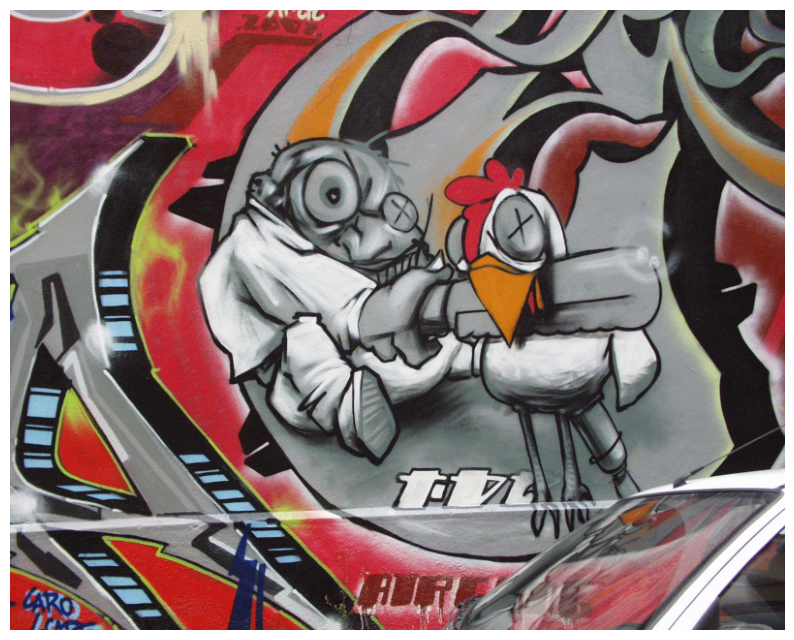

In [ ]:
torch.manual_seed(0)

timg: torch.Tensor = imread("img1.ppm")

imshow(K.tensor_to_image(timg), 10, 10)

In the following section we are going to take the original image and generate random crops of a given size.

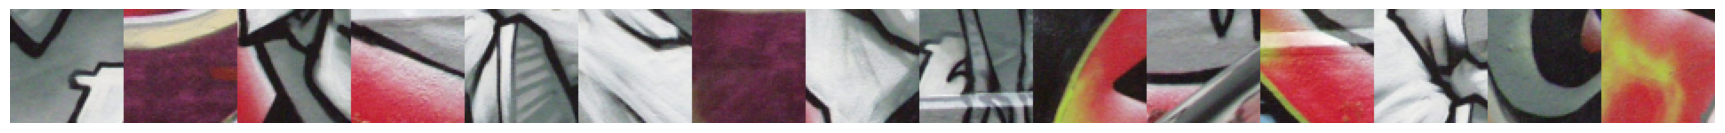

In [ ]:
random_crop = K.augmentation.RandomCrop((64, 64))

patch = torch.cat([random_crop(timg) for _ in range(15)], dim=-1)

imshow(K.tensor_to_image(patch[0]), 22, 22)

Next, we will show how to crop patches and apply forth and back random geometric transformations.

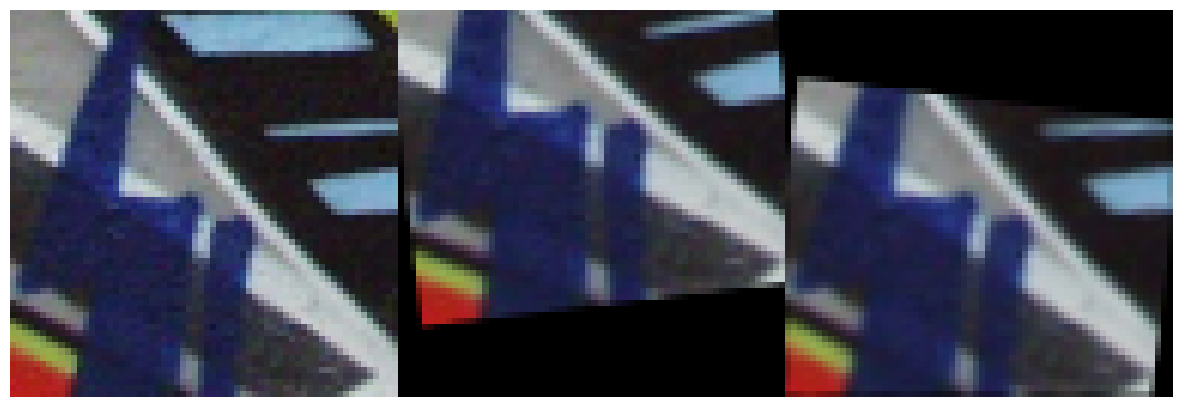

In [ ]:
# transform a patch

random_crop = K.augmentation.RandomCrop((64, 64))
random_affine = K.augmentation.RandomAffine([-15, 15], [0.0, 0.25])

# crop
patch = random_crop(timg)

# transform and retrieve transformation
patch_affine = random_affine(patch)
transformation = random_affine.get_transformation_matrix(patch)

# invert patch
_, _, H, W = patch.shape
patch_inv = K.geometry.warp_perspective(patch_affine, torch.inverse(transformation), (H, W))

# visualise - (original, transformed, reconstructed)
patches_vis = torch.cat([patch, patch_affine, patch_inv], dim=-1)
imshow(K.tensor_to_image(patches_vis), 15, 15)